In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import PIL
from PIL import Image

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense
from keras.layers import Convolution2D
from keras.layers import AveragePooling2D
from keras.layers import UpSampling2D
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Input
from keras.layers import Add, BatchNormalization, LeakyReLU,concatenate,PReLU,ELU
from keras.optimizers import Adam
import keras.backend as K

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
encoding_size = 128
perturbation_max = 40
smooth = 1.

In [3]:
preprocess = lambda x : x / 256
deprocess  = lambda x :(x * 256).astype(np.uint8)

In [4]:
preprocess = lambda x : x / 127 - 1
deprocess  = lambda x :((x + 1) * 127).astype(np.uint8)

In [5]:
import os
cwd = os.getcwd()
print(str(cwd))

D:\Nico\git\UKDDeepLearning


In [6]:
def soft_dice(y_pred, y_true):
    # y_pred is softmax output of shape (num_samples, num_classes)
    # y_true is one hot encoding of target (shape= (num_samples, num_classes))
    intersect = K.sum(y_pred * y_true, 0)
    denominator = K.sum(y_pred, 0) + K.sum(y_true, 0)
    dice_scores = K.constant(2) * intersect / (denominator + K.constant(1e-6)) # used to be 1e-6
    return dice_scores

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def soft_dice_loss(y_true, y_pred):
    return -soft_dice(y_true, y_pred)

In [7]:
def normalize(arr):
    """
    Linear normalization
    http://en.wikipedia.org/wiki/Normalization_%28image_processing%29
    """
    arr = arr.astype('float')
    minval = arr[...].min()
    maxval = arr[...].max()
    if minval != maxval:
        arr[...] -= minval
        arr[...] *= (255.0/(maxval-minval))
    return arr

In [8]:
img = normalize(np.array(PIL.Image.open('oct.tif')))
img = img[:,30:30+320]
img = img[...,np.newaxis]
preproc_img = preprocess(img)
image_shape = img.shape
#plt.imshow(deprocess(preproc_img))
print(str(img.shape))

(320, 320, 1)


1.0078740157480315


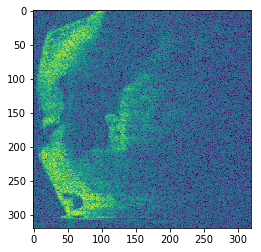

In [9]:
#corruption = np.random.randint(-perturbation_max, perturbation_max, size = image_shape)
corrupted_img = img.clip(0, 255)
preproc_corrupted_img = preprocess(corrupted_img)
print(str(np.max(preproc_corrupted_img)))
plt.imshow(np.squeeze(deprocess(preproc_corrupted_img)))

In [10]:
act = LeakyReLU()
noFeatures = 128
noFilters = 3
model_input = Input(shape = image_shape)
conv1       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(model_input)
conv2       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(conv1)

pool1       = AveragePooling2D()(conv2)
conv3       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(pool1)
conv4       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(conv3)

pool2       = AveragePooling2D()(conv4)
conv5       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(pool2)
conv6       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(conv5)

pool3       = AveragePooling2D()(conv6)
##flatten     = Flatten()(conv6)
##encoding    = Dense(encoding_size, activation = 'relu')(flatten)
##dense2      = Dense(400, activation = 'relu')(encoding)
##reshape     = Reshape((20,20, 1))(dense2)

enc1       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(pool3)
enc2       = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(enc1)

upsample2   = UpSampling2D(size = (2, 2))(enc2)
conv11      = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(upsample2)
conv12      = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(conv11)
#bn12 = BatchNormalization()(conv12)
add1        = concatenate([conv12, conv6])
upsample3   = UpSampling2D()(conv12)
conv13      = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(upsample3)
conv14      = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(conv13)
#bn14 = BatchNormalization()(conv14)
add2        = concatenate([conv14, conv4])
upsample3   = UpSampling2D()(add2)
conv15      = Convolution2D(noFeatures, noFilters, padding = 'same', activation = act, kernel_initializer = 'he_normal')(upsample3)
conv16      = Convolution2D(1, 1, padding = 'same', activation = act, kernel_initializer = 'he_normal')(conv15)
#conv17      = Convolution2D(1, 1, padding = 'same', activation = 'tanh')(conv16)

c:\users\user\anaconda3\envs\tensorflow\lib\site-packages\keras\activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [11]:
autoencoder = Model(model_input, conv16)
autoencoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 320, 320, 128 1280        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 320, 320, 128 147584      conv2d_1[0][0]                   
__________________________________________________________________________________________________
average_pooling2d_1 (AveragePoo (None, 160, 160, 128 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [12]:
autoencoder.compile(Adam(1e-5), loss = 'mse')

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [13]:
base_image = np.random.random(size = (1,) + image_shape)
base_image = np.random.random(size = (1,) + image_shape) * 2 - 1
corrupted_img_batch = np.expand_dims(preproc_corrupted_img, 0)
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 1000,
    'batch_size': 1,
    'verbose': 0
}

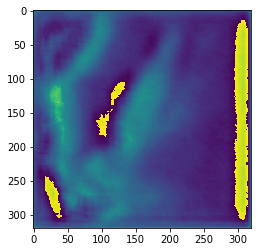

In [14]:
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))

In [ ]:
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
#MSE@10-6

In [ ]:
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
#SoftDICE1e-6@10-4

In [ ]:
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
#SoftDICE1e-3@10-4

Epoch 1/1000
1/1 [==============================] - 5s 5s/step - loss: 0.2095
Epoch 2/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.2084
Epoch 3/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.2072
Epoch 4/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.2060
Epoch 5/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.2047
Epoch 6/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.2034
Epoch 7/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.2021
Epoch 8/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.2008
Epoch 9/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1996
Epoch 10/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1983
Epoch 11/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1971
Epoch 12/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1958
Epoch 13/1000
1/1 [===============

Epoch 102/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1459
Epoch 103/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1456
Epoch 104/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1454
Epoch 105/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1452
Epoch 106/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1449
Epoch 107/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1447
Epoch 108/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1445
Epoch 109/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1443
Epoch 110/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1441
Epoch 111/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1439
Epoch 112/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1436
Epoch 113/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1434
Epoch 114/1

Epoch 202/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1290
Epoch 203/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1289
Epoch 204/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1287
Epoch 205/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1286
Epoch 206/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1284
Epoch 207/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1283
Epoch 208/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1282
Epoch 209/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1280
Epoch 210/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1279
Epoch 211/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1278
Epoch 212/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1276
Epoch 213/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1275
Epoch 214/100

Epoch 302/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1171
Epoch 303/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1170
Epoch 304/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1169
Epoch 305/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1168
Epoch 306/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1167
Epoch 307/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1166
Epoch 308/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1165
Epoch 309/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1165
Epoch 310/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1164
Epoch 311/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1163
Epoch 312/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1162
Epoch 313/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1161
Epoch 314/100

Epoch 402/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1106
Epoch 403/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1105
Epoch 404/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1105
Epoch 405/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1105
Epoch 406/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1104
Epoch 407/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1104
Epoch 408/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1104
Epoch 409/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1103
Epoch 410/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1103
Epoch 411/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1103
Epoch 412/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1102
Epoch 413/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1102
Epoch 414/100

Epoch 502/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1088
Epoch 503/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1088
Epoch 504/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1087
Epoch 505/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1087
Epoch 506/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1087
Epoch 507/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1087
Epoch 508/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1087
Epoch 509/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1087
Epoch 510/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1087
Epoch 511/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1087
Epoch 512/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1087
Epoch 513/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1087
Epoch 514/10

Epoch 602/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1083
Epoch 603/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1083
Epoch 604/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1083
Epoch 605/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1083
Epoch 606/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1083
Epoch 607/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1083
Epoch 608/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1083
Epoch 609/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1083
Epoch 610/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1082
Epoch 611/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1082
Epoch 612/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1082
Epoch 613/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1082
Epoch 

Epoch 701/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 702/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 703/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 704/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 705/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 706/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 707/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 708/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 709/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 710/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 711/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoch 712/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1079
Epoc

Epoch 800/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 801/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1075
Epoch 802/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 803/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 804/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1075
Epoch 805/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 806/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 807/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 808/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 809/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 810/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoch 811/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1075
Epoc

Epoch 899/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1072
Epoch 900/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1072
Epoch 901/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1072
Epoch 902/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1072
Epoch 903/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1072
Epoch 904/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1072
Epoch 905/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1071
Epoch 906/1000
1/1 [==============================] - 0s 94ms/step - loss: 0.1071
Epoch 907/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1071
Epoch 908/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1071
Epoch 909/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1071
Epoch 910/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1071
Epoch

Epoch 998/1000
1/1 [==============================] - 0s 125ms/step - loss: 0.1068
Epoch 999/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1068
Epoch 1000/1000
1/1 [==============================] - 0s 109ms/step - loss: 0.1068


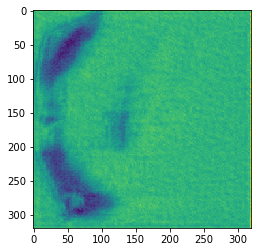

In [14]:
autoencoder.compile(Adam(1e-6), loss = 'mse')
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 1000,
    'batch_size': 0,
    'verbose': 1
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_imagePrior_mse.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(preproc_img)))))
final_img.save('oct_imagePrior_raw.tif')

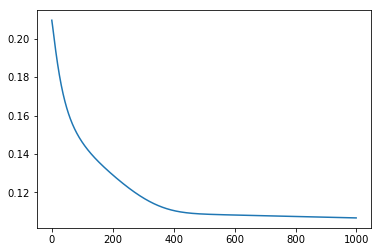

In [16]:
plt.plot(hist.history['loss'])

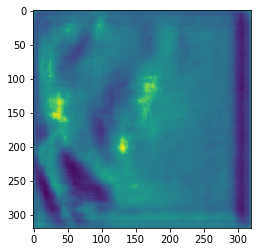

In [41]:
autoencoder.compile(Adam(1e-5), loss = 'mse')
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 1000,
    'batch_size': 1,
    'verbose': 0
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_imagePrior_mse.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(preproc_img)))))
final_img.save('oct_imagePrior_raw.tif')

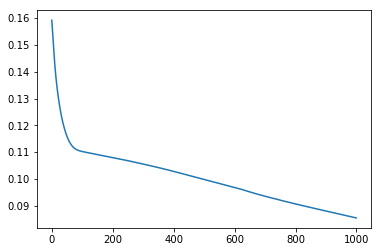

In [40]:
plt.plot(hist.history['loss'])

Epoch 1/10000
1/1 [==============================] - 1s 1s/step - loss: 0.0934
Epoch 2/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0931
Epoch 3/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0929
Epoch 4/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0927
Epoch 5/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 6/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0926
Epoch 7/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 8/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 9/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 10/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 11/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 12/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0926
Epoch 13/10000
1/1 [===

1/1 [==============================] - 0s 109ms/step - loss: 0.0914
Epoch 101/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0914
Epoch 102/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0914
Epoch 103/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0914
Epoch 104/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0913
Epoch 105/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0913
Epoch 106/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0913
Epoch 107/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0913
Epoch 108/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0913
Epoch 109/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0913
Epoch 110/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0913
Epoch 111/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0912
Epoch 11

Epoch 198/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0898
Epoch 199/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0898
Epoch 200/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0898
Epoch 201/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0898
Epoch 202/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0898
Epoch 203/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0897
Epoch 204/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0897
Epoch 205/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0897
Epoch 206/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0897
Epoch 207/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0897
Epoch 208/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0897
Epoch 209/10000
1/1 [==============================] - 0s 125ms/step - loss:

Epoch 296/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0884
Epoch 297/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0883
Epoch 298/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0883
Epoch 299/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0883
Epoch 300/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0883
Epoch 301/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0883
Epoch 302/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0883
Epoch 303/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0883
Epoch 304/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0882
Epoch 305/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0882
Epoch 306/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0882
Epoch 307/10000
1/1 [==============================] - 0s 109ms/step - loss:

Epoch 394/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0871
Epoch 395/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0871
Epoch 396/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0871
Epoch 397/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0871
Epoch 398/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0871
Epoch 399/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0870
Epoch 400/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0870
Epoch 401/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0870
Epoch 402/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0870
Epoch 403/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0870
Epoch 404/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0870
Epoch 405/10000
1/1 [==============================] - 0s 125ms/step - loss:

Epoch 492/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0859
Epoch 493/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0859
Epoch 494/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0859
Epoch 495/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0859
Epoch 496/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0859
Epoch 497/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0859
Epoch 498/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0859
Epoch 499/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0859
Epoch 500/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0858
Epoch 501/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0858
Epoch 502/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0858
Epoch 503/10000
1/1 [==============================] - 0s 109ms/step - loss:

Epoch 590/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0848
Epoch 591/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0848
Epoch 592/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0848
Epoch 593/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0847
Epoch 594/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0847
Epoch 595/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0847
Epoch 596/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0847
Epoch 597/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0847
Epoch 598/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0847
Epoch 599/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0847
Epoch 600/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0847
Epoch 601/10000
1/1 [==============================] - 0s 109ms/step - loss: 

Epoch 688/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0835
Epoch 689/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0835
Epoch 690/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0835
Epoch 691/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0835
Epoch 692/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0835
Epoch 693/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0835
Epoch 694/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0834
Epoch 695/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0834
Epoch 696/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0834
Epoch 697/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0834
Epoch 698/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0834
Epoch 699/10000
1/1 [==============================] - 0s 109ms/step - loss: 

Epoch 786/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0821
Epoch 787/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0821
Epoch 788/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0821
Epoch 789/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0821
Epoch 790/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0820
Epoch 791/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0820
Epoch 792/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0820
Epoch 793/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0820
Epoch 794/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0820
Epoch 795/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0820
Epoch 796/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0819
Epoch 797/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.

Epoch 884/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0804
Epoch 885/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0803
Epoch 886/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0803
Epoch 887/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0803
Epoch 888/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0803
Epoch 889/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0803
Epoch 890/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0802
Epoch 891/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0802
Epoch 892/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0802
Epoch 893/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0802
Epoch 894/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0802
Epoch 895/10000
1/1 [==============================] - 0s 125ms/step - loss: 

Epoch 982/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0782
Epoch 983/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0782
Epoch 984/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0781
Epoch 985/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0781
Epoch 986/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0781
Epoch 987/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0781
Epoch 988/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0780
Epoch 989/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0780
Epoch 990/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0780
Epoch 991/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0780
Epoch 992/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0779
Epoch 993/10000
1/1 [==============================] - 0s 109ms/step - loss:

Epoch 1079/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0754
Epoch 1080/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0754
Epoch 1081/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0753
Epoch 1082/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0753
Epoch 1083/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0753
Epoch 1084/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0752
Epoch 1085/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0752
Epoch 1086/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0752
Epoch 1087/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0751
Epoch 1088/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0751
Epoch 1089/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0751
Epoch 1090/10000
1/1 [==============================] - 0s 109ms/

Epoch 1176/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0724
Epoch 1177/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0723
Epoch 1178/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0723
Epoch 1179/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0723
Epoch 1180/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0722
Epoch 1181/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0722
Epoch 1182/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0722
Epoch 1183/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0721
Epoch 1184/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0721
Epoch 1185/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0721
Epoch 1186/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0720
Epoch 1187/10000
1/1 [==============================] - 0s 109ms/

Epoch 1273/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0693
Epoch 1274/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0692
Epoch 1275/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0692
Epoch 1276/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0692
Epoch 1277/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0691
Epoch 1278/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0691
Epoch 1279/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0691
Epoch 1280/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0691
Epoch 1281/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0690
Epoch 1282/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0690
Epoch 1283/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0690
Epoch 1284/10000
1/1 [==============================] - 0s 109ms/

Epoch 1370/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0665
Epoch 1371/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0665
Epoch 1372/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0665
Epoch 1373/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0664
Epoch 1374/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0664
Epoch 1375/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0664
Epoch 1376/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0663
Epoch 1377/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0663
Epoch 1378/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0663
Epoch 1379/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0663
Epoch 1380/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0662
Epoch 1381/10000
1/1 [==============================] - 0s 109ms/s

Epoch 1467/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0640
Epoch 1468/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0640
Epoch 1469/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0640
Epoch 1470/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0639
Epoch 1471/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0639
Epoch 1472/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0639
Epoch 1473/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0638
Epoch 1474/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0638
Epoch 1475/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0638
Epoch 1476/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0638
Epoch 1477/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0637
Epoch 1478/10000
1/1 [==============================] - 0s 109ms/

Epoch 1564/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0619
Epoch 1565/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0618
Epoch 1566/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0618
Epoch 1567/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0618
Epoch 1568/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0618
Epoch 1569/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0618
Epoch 1570/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0618
Epoch 1571/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0617
Epoch 1572/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0617
Epoch 1573/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0617
Epoch 1574/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0617
Epoch 1575/10000
1/1 [==============================] - 0s 109ms/

Epoch 1661/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0602
Epoch 1662/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0602
Epoch 1663/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0602
Epoch 1664/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0602
Epoch 1665/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0602
Epoch 1666/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0601
Epoch 1667/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0601
Epoch 1668/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0601
Epoch 1669/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0601
Epoch 1670/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0601
Epoch 1671/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0601
Epoch 1672/10000
1/1 [==============================] - 0s 109ms/

Epoch 1758/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0589
Epoch 1759/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0588
Epoch 1760/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0588
Epoch 1761/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0588
Epoch 1762/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0588
Epoch 1763/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0588
Epoch 1764/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0588
Epoch 1765/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0588
Epoch 1766/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0587
Epoch 1767/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0587
Epoch 1768/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0587
Epoch 1769/10000
1/1 [==============================] - 0s 109ms/

Epoch 1855/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0577
Epoch 1856/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0577
Epoch 1857/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0577
Epoch 1858/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0577
Epoch 1859/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0577
Epoch 1860/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0576
Epoch 1861/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0576
Epoch 1862/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0576
Epoch 1863/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0576
Epoch 1864/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0576
Epoch 1865/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0576
Epoch 1866/10000
1/1 [==============================] - 0s 109ms/s

Epoch 1952/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0568
Epoch 1953/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0568
Epoch 1954/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0568
Epoch 1955/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0567
Epoch 1956/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0567
Epoch 1957/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0567
Epoch 1958/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0567
Epoch 1959/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0567
Epoch 1960/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0567
Epoch 1961/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0567
Epoch 1962/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0567
Epoch 1963/10000
1/1 [==============================] - 0s 109ms/s

Epoch 2049/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2050/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2051/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0559
Epoch 2052/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0559
Epoch 2053/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2054/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2055/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0559
Epoch 2056/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2057/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2058/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2059/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0559
Epoch 2060/10000
1/1 [==============================] - 0s 109ms/s

Epoch 2146/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0552
Epoch 2147/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0552
Epoch 2148/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0552
Epoch 2149/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0551
Epoch 2150/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0551
Epoch 2151/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0551
Epoch 2152/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0551
Epoch 2153/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0551
Epoch 2154/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0551
Epoch 2155/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0551
Epoch 2156/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0551
Epoch 2157/10000
1/1 [==============================] - 0s 125ms/s

Epoch 2243/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0544
Epoch 2244/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0544
Epoch 2245/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0544
Epoch 2246/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0544
Epoch 2247/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0544
Epoch 2248/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0544
Epoch 2249/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0544
Epoch 2250/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0544
Epoch 2251/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0543
Epoch 2252/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0543
Epoch 2253/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0543
Epoch 2254/10000
1/1 [==============================] - 0s 125ms/

Epoch 2340/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2341/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2342/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2343/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2344/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2345/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2346/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2347/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0537
Epoch 2348/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2349/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0537
Epoch 2350/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0537
Epoch 2351/10000
1/1 [==============================] - 0s 125ms/

Epoch 2437/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0531
Epoch 2438/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2439/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2440/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2441/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2442/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2443/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2444/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2445/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0531
Epoch 2446/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0530
Epoch 2447/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0530
Epoch 2448/10000
1/1 [==============================] - 0s 109ms/

Epoch 2534/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2535/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2536/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2537/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2538/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2539/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0525
Epoch 2540/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2541/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2542/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2543/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0525
Epoch 2544/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0525
Epoch 2545/10000
1/1 [==============================] - 0s 125ms/s

Epoch 2631/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0520
Epoch 2632/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0520
Epoch 2633/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0520
Epoch 2634/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0519
Epoch 2635/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0519
Epoch 2636/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0519
Epoch 2637/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0519
Epoch 2638/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0519
Epoch 2639/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0519
Epoch 2640/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0519
Epoch 2641/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0519
Epoch 2642/10000
1/1 [==============================] - 0s 109ms/

Epoch 2728/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0515
Epoch 2729/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0515
Epoch 2730/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0515
Epoch 2731/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0515
Epoch 2732/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0515
Epoch 2733/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0514
Epoch 2734/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0514
Epoch 2735/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0514
Epoch 2736/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0514
Epoch 2737/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0514
Epoch 2738/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0514
Epoch 2739/10000
1/1 [==============================] - 0s 125ms/s

Epoch 2825/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0510
Epoch 2826/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0510
Epoch 2827/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0510
Epoch 2828/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0510
Epoch 2829/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0510
Epoch 2830/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0510
Epoch 2831/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0510
Epoch 2832/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0510
Epoch 2833/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0510
Epoch 2834/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0509
Epoch 2835/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0509
Epoch 2836/10000
1/1 [==============================] - 0s 125ms/

Epoch 2922/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0506
Epoch 2923/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0505
Epoch 2924/10000
1/1 [==============================] - 0s 266ms/step - loss: 0.0505
Epoch 2925/10000
1/1 [==============================] - 0s 121ms/step - loss: 0.0505
Epoch 2926/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0505
Epoch 2927/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0505
Epoch 2928/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0505
Epoch 2929/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0505
Epoch 2930/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0505
Epoch 2931/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0505
Epoch 2932/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0505
Epoch 2933/10000
1/1 [==============================] - 0s 111ms/

Epoch 3019/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0502
Epoch 3020/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0502
Epoch 3021/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0501
Epoch 3022/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0501
Epoch 3023/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0501
Epoch 3024/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0501
Epoch 3025/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0501
Epoch 3026/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0501
Epoch 3027/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0501
Epoch 3028/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0501
Epoch 3029/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0501
Epoch 3030/10000
1/1 [==============================] - 0s 109ms/

Epoch 3116/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3117/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3118/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3119/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3120/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3121/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3122/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3123/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0498
Epoch 3124/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3125/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3126/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0498
Epoch 3127/10000
1/1 [==============================] - 0s 109ms/

Epoch 3213/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0494
Epoch 3214/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0494
Epoch 3215/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0494
Epoch 3216/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0494
Epoch 3217/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0494
Epoch 3218/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0494
Epoch 3219/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0494
Epoch 3220/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0494
Epoch 3221/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0494
Epoch 3222/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0494
Epoch 3223/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0494
Epoch 3224/10000
1/1 [==============================] - 0s 109ms/

Epoch 3310/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3311/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0491
Epoch 3312/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3313/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3314/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3315/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0491
Epoch 3316/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3317/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3318/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0491
Epoch 3319/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3320/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0491
Epoch 3321/10000
1/1 [==============================] - 0s 109ms/s

Epoch 3407/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3408/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3409/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0488
Epoch 3410/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3411/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3412/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3413/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0488
Epoch 3414/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3415/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3416/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0488
Epoch 3417/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0488
Epoch 3418/10000
1/1 [==============================] - 0s 109ms/s

Epoch 3504/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3505/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0485
Epoch 3506/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3507/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3508/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3509/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3510/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0485
Epoch 3511/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3512/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3513/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0485
Epoch 3514/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0485
Epoch 3515/10000
1/1 [==============================] - 0s 109ms/

Epoch 3601/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3602/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3603/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0482
Epoch 3604/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3605/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3606/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0482
Epoch 3607/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3608/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0482
Epoch 3609/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0482
Epoch 3610/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3611/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0482
Epoch 3612/10000
1/1 [==============================] - 0s 109ms/

Epoch 3698/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0480
Epoch 3699/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0480
Epoch 3700/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0480
Epoch 3701/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0480
Epoch 3702/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0480
Epoch 3703/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0479
Epoch 3704/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0479
Epoch 3705/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0479
Epoch 3706/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0479
Epoch 3707/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0479
Epoch 3708/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0479
Epoch 3709/10000
1/1 [==============================] - 0s 109ms/

Epoch 3795/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0477
Epoch 3796/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0477
Epoch 3797/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0477
Epoch 3798/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0477
Epoch 3799/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0477
Epoch 3800/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0477
Epoch 3801/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0477
Epoch 3802/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0477
Epoch 3803/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0477
Epoch 3804/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0477
Epoch 3805/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0477
Epoch 3806/10000
1/1 [==============================] - 0s 109ms/st

Epoch 3892/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0475
Epoch 3893/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3894/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3895/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3896/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0475
Epoch 3897/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3898/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3899/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3900/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3901/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0475
Epoch 3902/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0475
Epoch 3903/10000
1/1 [==============================] - 0s 109ms/

Epoch 3989/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0473
Epoch 3990/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0473
Epoch 3991/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0473
Epoch 3992/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3993/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3994/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3995/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3996/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3997/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3998/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 3999/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0472
Epoch 4000/10000
1/1 [==============================] - 0s 109ms/

Epoch 4086/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0470
Epoch 4087/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0470
Epoch 4088/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0470
Epoch 4089/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0470
Epoch 4090/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0470
Epoch 4091/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0470
Epoch 4092/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0470
Epoch 4093/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0470
Epoch 4094/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0470
Epoch 4095/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0470
Epoch 4096/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0470
Epoch 4097/10000
1/1 [==============================] - 0s 125ms/s

Epoch 4183/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0468
Epoch 4184/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0468
Epoch 4185/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0468
Epoch 4186/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0468
Epoch 4187/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0468
Epoch 4188/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0468
Epoch 4189/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0469
Epoch 4190/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0469
Epoch 4191/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0469
Epoch 4192/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0469
Epoch 4193/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0469
Epoch 4194/10000
1/1 [==============================] - 0s 125ms/

Epoch 4280/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4281/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4282/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4283/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4284/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0466
Epoch 4285/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0466
Epoch 4286/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0466
Epoch 4287/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4288/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4289/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4290/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0466
Epoch 4291/10000
1/1 [==============================] - 0s 125ms/

Epoch 4377/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0465
Epoch 4378/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0465
Epoch 4379/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0465
Epoch 4380/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0465
Epoch 4381/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0464
Epoch 4382/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0464
Epoch 4383/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0464
Epoch 4384/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0464
Epoch 4385/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0464
Epoch 4386/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0464
Epoch 4387/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0464
Epoch 4388/10000
1/1 [==============================] - 0s 109ms/

Epoch 4474/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0463
Epoch 4475/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4476/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4477/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4478/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0463
Epoch 4479/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4480/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4481/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0463
Epoch 4482/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4483/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4484/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0463
Epoch 4485/10000
1/1 [==============================] - 0s 125ms/s

Epoch 4571/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4572/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4573/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4574/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4575/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0461
Epoch 4576/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4577/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4578/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4579/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4580/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0461
Epoch 4581/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0461
Epoch 4582/10000
1/1 [==============================] - 0s 109ms/

Epoch 4668/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4669/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4670/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0459
Epoch 4671/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4672/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4673/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4674/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4675/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4676/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4677/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0459
Epoch 4678/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0459
Epoch 4679/10000
1/1 [==============================] - 0s 109ms/

Epoch 4765/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4766/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4767/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4768/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4769/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0458
Epoch 4770/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4771/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4772/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0458
Epoch 4773/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4774/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0458
Epoch 4775/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0458
Epoch 4776/10000
1/1 [==============================] - 0s 125ms/

Epoch 4862/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0456
Epoch 4863/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4864/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4865/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4866/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4867/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0456
Epoch 4868/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4869/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4870/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4871/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0456
Epoch 4872/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0456
Epoch 4873/10000
1/1 [==============================] - 0s 109ms/s

Epoch 4959/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4960/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4961/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0455
Epoch 4962/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0455
Epoch 4963/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4964/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0455
Epoch 4965/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4966/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4967/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4968/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0455
Epoch 4969/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0455
Epoch 4970/10000
1/1 [==============================] - 0s 109ms/

Epoch 5056/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5057/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0454
Epoch 5058/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5059/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0454
Epoch 5060/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5061/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5062/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5063/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5064/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0454
Epoch 5065/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0454
Epoch 5066/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5067/10000
1/1 [==============================] - 0s 109ms/s

Epoch 5153/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5154/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0454
Epoch 5155/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0453
Epoch 5156/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0452
Epoch 5157/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0452
Epoch 5158/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0453
Epoch 5159/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0453
Epoch 5160/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0453
Epoch 5161/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0452
Epoch 5162/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0452
Epoch 5163/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0453
Epoch 5164/10000
1/1 [==============================] - 0s 109ms/

Epoch 5250/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5251/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5252/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5253/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5254/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0451
Epoch 5255/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0451
Epoch 5256/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5257/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5258/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5259/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0451
Epoch 5260/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0451
Epoch 5261/10000
1/1 [==============================] - 0s 109ms/st

Epoch 5347/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5348/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0450
Epoch 5349/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5350/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5351/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5352/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0450
Epoch 5353/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5354/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5355/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5356/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5357/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0450
Epoch 5358/10000
1/1 [==============================] - 0s 109ms/s

Epoch 5444/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5445/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5446/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5447/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5448/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5449/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5450/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5451/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5452/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5453/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5454/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0449
Epoch 5455/10000
1/1 [==============================] - 0s 109ms/

Epoch 5541/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5542/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0448
Epoch 5543/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5544/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5545/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5546/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5547/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5548/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5549/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5550/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0448
Epoch 5551/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0448
Epoch 5552/10000
1/1 [==============================] - 0s 109ms/s

Epoch 5638/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5639/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5640/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5641/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0447
Epoch 5642/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5643/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5644/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0447
Epoch 5645/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0447
Epoch 5646/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5647/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5648/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0447
Epoch 5649/10000
1/1 [==============================] - 0s 109ms/

Epoch 5735/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5736/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5737/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5738/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5739/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5740/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5741/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5742/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5743/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5744/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0446
Epoch 5745/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0446
Epoch 5746/10000
1/1 [==============================] - 0s 109ms/

Epoch 5832/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5833/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0445
Epoch 5834/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5835/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0445
Epoch 5836/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5837/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5838/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5839/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0445
Epoch 5840/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5841/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0445
Epoch 5842/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5843/10000
1/1 [==============================] - 0s 125ms/

Epoch 5929/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5930/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5931/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5932/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0444
Epoch 5933/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5934/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5935/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5936/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0444
Epoch 5937/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0444
Epoch 5938/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5939/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0444
Epoch 5940/10000
1/1 [==============================] - 0s 109ms/

Epoch 6026/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0443
Epoch 6027/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0443
Epoch 6028/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6029/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6030/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0443
Epoch 6031/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6032/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6033/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6034/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0443
Epoch 6035/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6036/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0443
Epoch 6037/10000
1/1 [==============================] - 0s 109ms/s

Epoch 6123/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0442
Epoch 6124/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0442
Epoch 6125/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0442
Epoch 6126/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0442
Epoch 6127/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0442
Epoch 6128/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0442
Epoch 6129/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0442
Epoch 6130/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0442
Epoch 6131/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0442
Epoch 6132/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0442
Epoch 6133/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0442
Epoch 6134/10000
1/1 [==============================] - 0s 109ms/

Epoch 6220/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0441
Epoch 6221/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0441
Epoch 6222/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0441
Epoch 6223/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0441
Epoch 6224/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0441
Epoch 6225/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0441
Epoch 6226/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0441
Epoch 6227/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0441
Epoch 6228/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0441
Epoch 6229/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0441
Epoch 6230/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0441
Epoch 6231/10000
1/1 [==============================] - 0s 125ms/

Epoch 6317/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0440
Epoch 6318/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6319/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6320/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0440
Epoch 6321/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6322/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6323/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6324/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6325/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0440
Epoch 6326/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0440
Epoch 6327/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0440
Epoch 6328/10000
1/1 [==============================] - 0s 109ms/

Epoch 6414/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0439
Epoch 6415/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6416/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6417/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6418/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6419/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6420/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6421/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0439
Epoch 6422/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6423/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0439
Epoch 6424/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0439
Epoch 6425/10000
1/1 [==============================] - 0s 125ms/

Epoch 6511/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6512/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6513/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6514/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6515/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6516/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6517/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6518/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6519/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6520/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6521/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6522/10000
1/1 [==============================] - 0s 109ms/

Epoch 6608/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6609/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6610/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6611/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6612/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6613/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6614/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6615/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6616/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0437
Epoch 6617/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0438
Epoch 6618/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0438
Epoch 6619/10000
1/1 [==============================] - 0s 109ms/

Epoch 6705/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0437
Epoch 6706/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0437
Epoch 6707/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6708/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6709/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0437
Epoch 6710/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0437
Epoch 6711/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6712/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6713/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6714/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6715/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0437
Epoch 6716/10000
1/1 [==============================] - 0s 94ms/ste

Epoch 6802/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0436
Epoch 6803/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6804/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6805/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0436
Epoch 6806/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6807/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6808/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6809/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6810/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6811/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6812/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0436
Epoch 6813/10000
1/1 [==============================] - 0s 109ms/

Epoch 6899/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 6900/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6901/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6902/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6903/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 6904/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6905/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6906/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 6907/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 6908/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6909/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 6910/10000
1/1 [==============================] - 0s 125ms/

Epoch 6996/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6997/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6998/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0435
Epoch 6999/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7000/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7001/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7002/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7003/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7004/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0435
Epoch 7005/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7006/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0435
Epoch 7007/10000
1/1 [==============================] - 0s 109ms/s

Epoch 7093/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7094/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7095/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0434
Epoch 7096/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7097/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7098/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7099/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7100/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0434
Epoch 7101/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0434
Epoch 7102/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0434
Epoch 7103/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0434
Epoch 7104/10000
1/1 [==============================] - 0s 140ms/

Epoch 7190/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7191/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7192/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7193/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7194/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7195/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7196/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7197/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7198/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7199/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7200/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7201/10000
1/1 [==============================] - 0s 109ms/

Epoch 7287/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7288/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7289/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7290/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7291/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7292/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7293/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7294/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7295/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7296/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0433
Epoch 7297/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0433
Epoch 7298/10000
1/1 [==============================] - 0s 109ms/

Epoch 7384/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0432
Epoch 7385/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7386/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7387/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7388/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7389/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7390/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7391/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0432
Epoch 7392/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7393/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0432
Epoch 7394/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0432
Epoch 7395/10000
1/1 [==============================] - 0s 109ms/

Epoch 7481/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7482/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7483/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7484/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7485/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7486/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7487/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7488/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7489/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7490/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7491/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7492/10000
1/1 [==============================] - 0s 109ms/

Epoch 7578/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7579/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7580/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7581/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7582/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7583/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7584/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7585/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7586/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7587/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0431
Epoch 7588/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0431
Epoch 7589/10000
1/1 [==============================] - 0s 125ms/

Epoch 7675/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7676/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7677/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7678/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7679/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7680/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7681/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7682/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7683/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7684/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7685/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7686/10000
1/1 [==============================] - 0s 125ms/

Epoch 7772/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7773/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7774/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7775/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7776/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7777/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0430
Epoch 7778/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7779/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7780/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7781/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0430
Epoch 7782/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0430
Epoch 7783/10000
1/1 [==============================] - 0s 125ms/s

Epoch 7869/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7870/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7871/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7872/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7873/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7874/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7875/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7876/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7877/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7878/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7879/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7880/10000
1/1 [==============================] - 0s 125ms/

Epoch 7966/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7967/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7968/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7969/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0429
Epoch 7970/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0429
Epoch 7971/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 7972/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 7973/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 7974/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 7975/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0428
Epoch 7976/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 7977/10000
1/1 [==============================] - 0s 109ms/

Epoch 8063/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0428
Epoch 8064/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8065/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8066/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8067/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8068/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8069/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8070/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8071/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8072/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0428
Epoch 8073/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0428
Epoch 8074/10000
1/1 [==============================] - 0s 109ms/

Epoch 8160/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8161/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8162/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8163/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8164/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8165/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8166/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8167/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8168/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8169/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8170/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8171/10000
1/1 [==============================] - 0s 109ms/

Epoch 8257/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8258/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8259/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8260/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8261/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8262/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8263/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8264/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8265/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8266/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0427
Epoch 8267/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0427
Epoch 8268/10000
1/1 [==============================] - 0s 109ms/

Epoch 8354/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8355/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8356/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8357/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8358/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8359/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8360/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8361/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8362/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8363/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8364/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8365/10000
1/1 [==============================] - 0s 109ms/

Epoch 8451/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8452/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8453/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8454/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8455/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8456/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8457/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8458/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8459/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8460/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8461/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8462/10000
1/1 [==============================] - 0s 109ms/

Epoch 8548/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8549/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8550/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8551/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8552/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8553/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0426
Epoch 8554/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0426
Epoch 8555/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8556/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0425
Epoch 8557/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0425
Epoch 8558/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8559/10000
1/1 [==============================] - 0s 125ms/

Epoch 8645/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8646/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0425
Epoch 8647/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8648/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8649/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8650/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0425
Epoch 8651/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0425
Epoch 8652/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8653/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8654/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8655/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0425
Epoch 8656/10000
1/1 [==============================] - 0s 109ms/

Epoch 8742/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8743/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8744/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8745/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8746/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8747/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8748/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8749/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8750/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8751/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8752/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8753/10000
1/1 [==============================] - 0s 125ms/

Epoch 8839/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8840/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8841/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8842/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8843/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8844/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8845/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8846/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8847/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8848/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0424
Epoch 8849/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0424
Epoch 8850/10000
1/1 [==============================] - 0s 109ms/

Epoch 8936/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8937/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8938/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8939/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8940/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8941/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 8942/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 8943/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 8944/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8945/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8946/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 8947/10000
1/1 [==============================] - 0s 109ms/

Epoch 9033/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9034/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9035/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9036/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9037/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9038/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9039/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9040/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9041/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9042/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9043/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9044/10000
1/1 [==============================] - 0s 109ms/

Epoch 9130/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9131/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9132/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9133/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9134/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9135/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9136/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0423
Epoch 9137/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9138/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9139/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9140/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0423
Epoch 9141/10000
1/1 [==============================] - 0s 125ms/

Epoch 9227/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9228/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0422
Epoch 9229/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0422
Epoch 9230/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9231/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9232/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9233/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9234/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9235/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9236/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9237/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9238/10000
1/1 [==============================] - 0s 109ms/

Epoch 9324/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9325/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0422
Epoch 9326/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9327/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9328/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9329/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0422
Epoch 9330/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9331/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0422
Epoch 9332/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0422
Epoch 9333/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9334/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0422
Epoch 9335/10000
1/1 [==============================] - 0s 109ms/s

Epoch 9421/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9422/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9423/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9424/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9425/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9426/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0421
Epoch 9427/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9428/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9429/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9430/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9431/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9432/10000
1/1 [==============================] - 0s 109ms/

Epoch 9518/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9519/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9520/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9521/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9522/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9523/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9524/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0421
Epoch 9525/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9526/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0421
Epoch 9527/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9528/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9529/10000
1/1 [==============================] - 0s 94ms/s

Epoch 9615/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9616/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9617/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9618/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0421
Epoch 9619/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0421
Epoch 9620/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0421
Epoch 9621/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9622/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9623/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9624/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9625/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9626/10000
1/1 [==============================] - 0s 109ms/

Epoch 9712/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9713/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9714/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9715/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9716/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9717/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9718/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9719/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9720/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9721/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9722/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9723/10000
1/1 [==============================] - 0s 109ms/

Epoch 9809/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9810/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9811/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9812/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9813/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9814/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9815/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9816/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9817/10000
1/1 [==============================] - 0s 125ms/step - loss: 0.0420
Epoch 9818/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9819/10000
1/1 [==============================] - 0s 140ms/step - loss: 0.0420
Epoch 9820/10000
1/1 [==============================] - 0s 109ms/

Epoch 9906/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0420
Epoch 9907/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9908/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0419
Epoch 9909/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0419
Epoch 9910/10000
1/1 [==============================] - 0s 94ms/step - loss: 0.0419
Epoch 9911/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9912/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9913/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9914/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9915/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9916/10000
1/1 [==============================] - 0s 109ms/step - loss: 0.0419
Epoch 9917/10000
1/1 [==============================] - 0s 109ms/ste

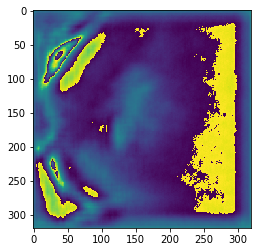

In [18]:
autoencoder.compile(Adam(1e-6), loss = 'mse')
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 10000,
    'batch_size': 1,
    'verbose': 1
}
hist2 = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_imagePrior_mse_10k.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(preproc_img)))))
final_img.save('oct_imagePrior_raw.tif')

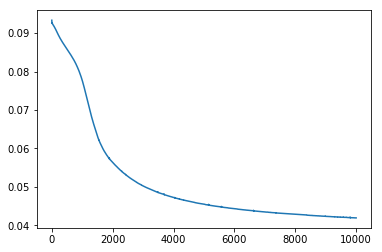

In [19]:
plt.plot(hist2.history['loss'])

In [ ]:
autoencoder.compile(Adam(1e-4), loss = soft_dice)
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 1000,
    'batch_size': 1,
    'verbose': 0
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
#MAE@10-3
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_imagePrior_sd.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(preproc_img)))))
final_img.save('oct_imagePrior_raw.tif')

In [ ]:
autoencoder.compile(Adam(1e-4), loss = 'mae')
fit_params = {
    'x': base_image,
    'y': corrupted_img_batch,
    'epochs': 1000,
    'batch_size': 1,
    'verbose': 0
}
hist = autoencoder.fit(**fit_params)
img_pred = autoencoder.predict(corrupted_img_batch)
plt.imshow(np.squeeze(deprocess(img_pred[0])))
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(img_pred[0])))))
final_img.save('oct_imagePrior_mae.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(normalize(deprocess(preproc_img)))))
final_img.save('oct_imagePrior_raw.tif')

In [ ]:
final_img = Image.fromarray(np.squeeze(np.uint8(deprocess(img_pred[0]))))
final_img.save('oct_imagePrior_mse.tif')
final_img = Image.fromarray(np.squeeze(np.uint8(deprocess(preproc_img))))
final_img.save('oct_imagePrior_raw.tif')

In [ ]:
plt.plot(hist.history['loss'])

In [ ]:
plt.imshow(np.squeeze(deprocess(img_pred[0])-deprocess(preproc_corrupted_img)))

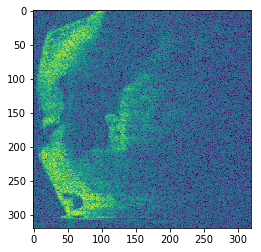

In [15]:
plt.imshow(np.squeeze(deprocess(preproc_corrupted_img)))